In [21]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

# Load the dataset
data = pd.read_csv('../../data/Synthetic/reData.csv')



In [22]:
def convert_values(val):
    if 0 <= val < 2:
        return '0 - 2'
    elif 2 <= val < 4:
        return '2 - 4'
    elif 4 <= val < 6:
        return '4 - 6'   
    elif 6 <= val < 8:
        return '6 - 8'
    elif 8 <= val < 10:
        return '8 - 10'        
    elif val >= 10:
        return 'More than 10'
    else:
        return str(val)

data['Monthly_Data_Usage'] = data['Monthly_Data_Usage'].apply(convert_values)

In [23]:
data.head()

,Gender,College,Churn,Level,Residence,SIM_Usage,Usage_Freq,Network_Strength,Voice_Calls,Mobile_Data_Internet,SMS_Text_Messaging,Data_Exhaustion,Other_Networks,Poor_Network_Quality_Coverage,Insufficient_Data_Allowance,Unsatisfactory_Customer_Service,High_Costs_Pricing,Monthly_Data_Usage
0,Female,College of Humanities and Social Sciences,No,100,On-campus,No,Occasionally,4,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,8 - 10
1,Male,College of Humanities and Social Sciences,Yes,100,Off-campus,No,Several times a week,5,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,0 - 2
2,Male,College of Art and Built Environment,No,200,Off-campus,No,Never,1,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,8 - 10
3,Female,College of Humanities and Social Sciences,No,400,On-campus,Yes,Daily,4,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,2 - 4
4,Female,College of Humanities and Social Sciences,Yes,400,On-campus,Yes,Occasionally,5,No,No,Yes,Yes,Yes,No,No,No,Yes,0 - 2


>  Models to be used
* Cox Proportional Hazards Model: This model assumes that the effects of the predictors are multiplicative with respect to the hazard and are constant over time (proportional hazards assumption). If these assumptions hold true for your data, the Cox model can provide interpretable parameters and is widely used in medical research.
* Random Survival Forest Model: This model is a type of ensemble method that can handle more complex interactions between variables and doesn’t make the proportional hazards assumption. It can be more accurate if there are complex, non-linear relationships in your data.

In [24]:
import numpy as np
# Preprocess the data
# Encode categorical variables
label_encoders = {}
categorical_columns = ['Gender', 'College', 'Churn', 'Level', 'Residence', 'SIM_Usage',
       'Usage_Freq', 'Network_Strength', 'Voice_Calls',
       'Mobile_Data_Internet', 'SMS_Text_Messaging', 'Data_Exhaustion',
       'Other_Networks', 'Poor_Network_Quality_Coverage',
       'Insufficient_Data_Allowance', 'Unsatisfactory_Customer_Service',
       'High_Costs_Pricing','Monthly_Data_Usage']

for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Prepare data for survival analysis
X = data.drop(columns=['Monthly_Data_Usage', 'Churn'])
y = data[['Monthly_Data_Usage', 'Churn']].copy()
y['Churn'] = y['Churn'].astype(bool)
y = y.to_records(index=False)

# Cox Proportional Hazards Model
cph = CoxPHFitter()
cph.fit(data, duration_col='Monthly_Data_Usage', event_col='Churn')
cph.print_summary()

# Predict churn probabilities using Cox model
data['Cox_Predicted_Churn_Probability'] = cph.predict_partial_hazard(data)
print(data[['Cox_Predicted_Churn_Probability', 'Churn']])

# Kaplan-Meier Estimator
kmf = KaplanMeierFitter()
kmf.fit(data['Monthly_Data_Usage'], event_observed=data['Churn'])
data['Kaplan_Meier_Predicted_Survival_Probability'] = kmf.predict(data['Monthly_Data_Usage']).values
print(data[['Kaplan_Meier_Predicted_Survival_Probability', 'Churn']])

# Convert 'Churn' column to boolean
data['Churn'] = data['Churn'].astype(bool)

# Create a structured array for 'y'
y = np.array([(e, t) for e, t in zip(data['Churn'], data['Monthly_Data_Usage'])], dtype=[('Churn', np.bool_), ('Monthly_Data_Usage', np.float64)])

# Random Survival Forest Model
rsf = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf.fit(X, y)
# Random Survival Forest Model
rsf = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf.fit(X, y)


# Predict churn probabilities using Random Survival Forest
rsf_pred = rsf.predict(X)
data['RSF_Predicted_Churn_Probability'] = rsf_pred
print(data[['RSF_Predicted_Churn_Probability', 'Churn']])

# Evaluate the models using Concordance Index
cox_cindex = concordance_index(data['Monthly_Data_Usage'], -data['Cox_Predicted_Churn_Probability'], data['Churn'])
print(f'Cox Proportional Hazards Model Concordance Index: {cox_cindex}')

rsf_cindex = concordance_index_censored(y['Churn'], y['Monthly_Data_Usage'], rsf_pred)
print(f'Random Survival Forest Model Concordance Index: {rsf_cindex[0]}')


<lifelines.CoxPHFitter: fitted with 768 total observations, 522 right-censored observations>
             duration col = 'Monthly_Data_Usage'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 768
number of events observed = 246
   partial log-likelihood = -1221.64
         time fit was run = 2024-06-12 16:17:17 UTC

---
                                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                        
Gender                           0.04      1.04      0.13           -0.22            0.30                0.80                1.35
College                         -0.04      0.96      0.04           -0.12            0.04                0.89                1.04
Level                           -0.09      0.91      0.05           -0.19            0.01                0.82                1.01
Residence                       -0.07      0.93      0.17           -0.40            0.25                0.67                1.29
SIM_Usage                        0.03      1.04      0.13           -0.22            0.29                0.80                1.34
Usage_Freq                      -0.02      0.98      0.04           -0.10            0.06                0.91                1.07
Network_Strength                -0.00      1.00      0.05           -0.10            0.09                0.91                1.10
Voice_Calls                     -0.00      1.00      0.17           -0.33            0.32                0.72                1.38
Mobile_Data_Internet             0.01      1.01      0.17           -0.32            0.35                0.72                1.42
SMS_Text_Messaging              -0.18      0.84      0.18           -0.52            0.17                0.59                1.18
Data_Exhaustion                 -0.16      0.85      0.14           -0.43            0.11                0.65                1.11
Other_Networks                  -0.32      0.73      0.23           -0.77            0.13                0.46                1.13
Poor_Network_Quality_Coverage   -0.74      0.48      0.17           -1.08           -0.41                0.34                0.67
Insufficient_Data_Allowance     -1.11      0.33      0.19           -1.49           -0.74                0.23                0.48
Unsatisfactory_Customer_Service -0.76      0.47      0.19           -1.14           -0.38                0.32                0.68
High_Costs_Pricing              -0.83      0.44      0.18           -1.19           -0.47                0.31                0.62

                                 cmp to     z      p  -log2(p)
covariate                                                     
Gender                             0.00  0.29   0.77      0.37
College                            0.00 -1.04   0.30      1.74
Level                              0.00 -1.77   0.08      3.70
Residence                          0.00 -0.43   0.67      0.58
SIM_Usage                          0.00  0.26   0.79      0.34
Usage_Freq                         0.00 -0.38   0.70      0.51
Network_Strength                   0.00 -0.03   0.97      0.04
Voice_Calls                        0.00 -0.03   0.98      0.03
Mobile_Data_Internet               0.00  0.08   0.93      0.10
SMS_Text_Messaging                 0.00 -1.00   0.32      1.66
Data_Exhaustion                    0.00 -1.18   0.24      2.07
Other_Networks                     0.00 -1.41   0.16      2.65
Poor_Network_Quality_Coverage      0.00 -4.35 <0.005     16.19
Insufficient_Data_Allowance        0.00 -5.87 <0.005     27.76
Unsatisfactory_Customer_Service    0.00 -3.92 <0.005     13.46
High_Costs_Pricing                 0.00 -4.54 <0.005     17.46
---
Concordance = 0.87
Partial AIC = 2475.29
log-likelihood ratio test = 434.36 on 16 df
-log2(p) of ll-ratio test = 271.24

     Cox_Predicted_Churn_Probability  Churn
0                           0.389971      0
1                           6.286071      1
2                           0.535817      0
3                           0.370572      0
4                           4.133227      1
..                               ...    ...
763                         0.575236      0
764                         0.285905      0
765                         0.394883      0
766                         0.947885      0
767                         0.359253      0

[768 rows x 2 columns]
     Kaplan_Meier_Predicted_Survival_Probability  Churn
0                                       0.459390      0
1                                       0.942708      1
2                                       0.459390      0
3                                       0.873102      0
4                                       0.942708      1
..                                           ...    ...
763                                     0.459390      0


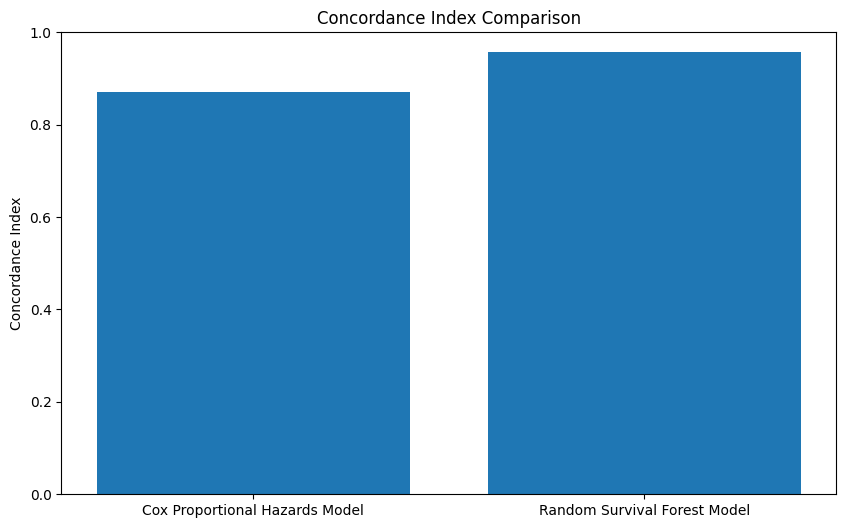

In [31]:
import matplotlib.pyplot as plt

# ... Your existing code ...

# Calculate the Concordance Indexes
cox_cindex = concordance_index(data['Monthly_Data_Usage'], -data['Cox_Predicted_Churn_Probability'], data['Churn'])
rsf_cindex = concordance_index_censored(y['Churn'], y['Monthly_Data_Usage'], rsf_pred)[0]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(['Cox Proportional Hazards Model', 'Random Survival Forest Model'], [cox_cindex, rsf_cindex])
plt.title('Concordance Index Comparison')
plt.ylabel('Concordance Index')
plt.ylim([0, 1])  # The Concordance Index ranges from 0 to 1
plt.show()


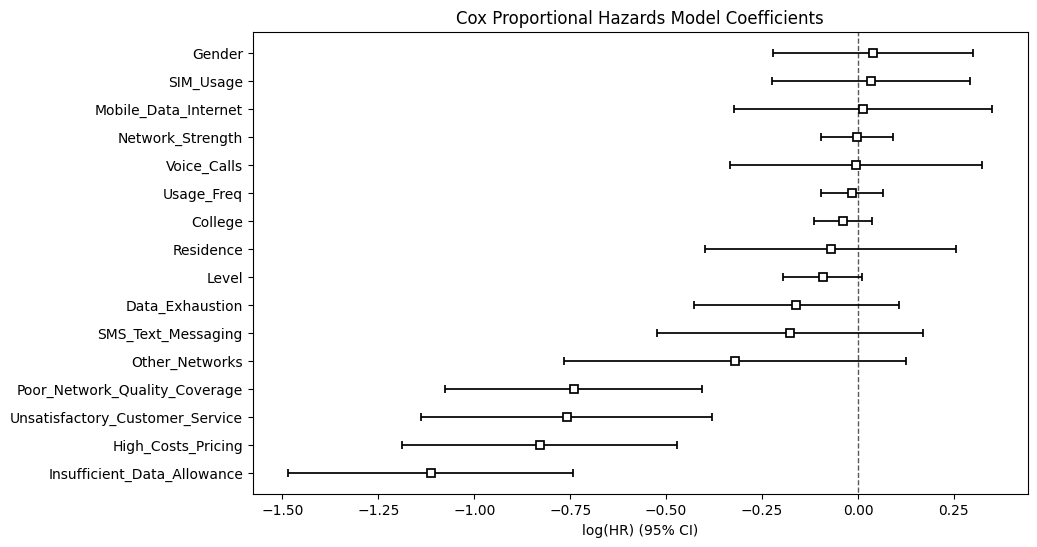

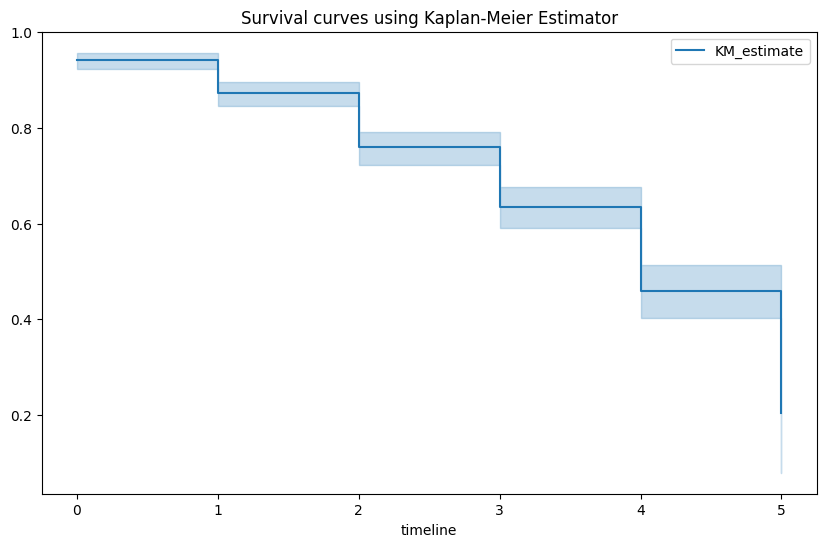

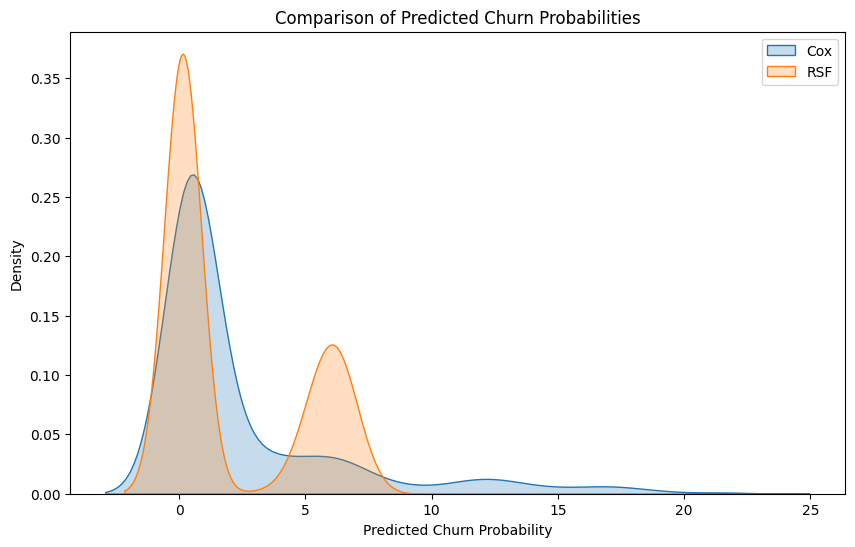

Cox Proportional Hazards Model Concordance Index: 0.8717
Random Survival Forest Model Concordance Index: 0.9569


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the coefficients of the Cox Proportional Hazards Model
plt.figure(figsize=(10, 6))
cph.plot()
plt.title('Cox Proportional Hazards Model Coefficients')
plt.show()

# Plotting the survival curves using Kaplan-Meier Estimator
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Survival curves using Kaplan-Meier Estimator')
plt.show()

# Comparing the predicted churn probabilities
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x='Cox_Predicted_Churn_Probability', label='Cox', fill=True)
sns.kdeplot(data=data, x='RSF_Predicted_Churn_Probability', label='RSF', fill=True)
plt.title('Comparison of Predicted Churn Probabilities')
plt.xlabel('Predicted Churn Probability')
plt.ylabel('Density')
plt.legend()
plt.show()

# Printing the Concordance Indexes
print(f'Cox Proportional Hazards Model Concordance Index: {cox_cindex:.4f}')
print(f'Random Survival Forest Model Concordance Index: {rsf_cindex[0]:.4f}')


In [29]:
# import plotly.graph_objects as go


# # Plotting the coefficients of the Cox Proportional Hazards Model
# fig = go.Figure(data=go.Bar(y=cph.params_, x=data.columns))
# fig.update_layout(title_text='Cox Proportional Hazards Model Coefficients', xaxis_title='Features', yaxis_title='Coefficient')
# fig.show()

# # Plotting the survival curves using Kaplan-Meier Estimator
# fig = go.Figure(data=go.Scatter(x=kmf.survival_function_.index, y=kmf.survival_function_.values.flatten(), mode='lines'))
# fig.update_layout(title_text='Survival curves using Kaplan-Meier Estimator', xaxis_title='Time', yaxis_title='Survival Probability')
# fig.show()

# # Comparing the predicted churn probabilities
# fig = go.Figure()
# fig.add_trace(go.Histogram(x=data['Cox_Predicted_Churn_Probability'], name='Cox', histnorm='probability density'))
# fig.add_trace(go.Histogram(x=data['RSF_Predicted_Churn_Probability'], name='RSF', histnorm='probability density'))
# fig.update_layout(title_text='Comparison of Predicted Churn Probabilities', xaxis_title='Predicted Churn Probability', yaxis_title='Density', barmode='overlay')
# fig.show()

# # Printing the Concordance Indexes
# print(f'Cox Proportional Hazards Model Concordance Index: {cox_cindex:.4f}')
# print(f'Random Survival Forest Model Concordance Index: {rsf_cindex[0]:.4f}')
